In [4]:
import numpy as np
import pandas as pd
import scanpy as sc # v1.4.3\n",
import sys
import bbknn
from statsmodels import robust
import sys
import matplotlib.pyplot as plt
import os.path
import scipy

In [6]:
#Alex's scoring function

def assign_cats(adata, dict_cats, column_groupby='leiden', quantile_gene_sel=0.7, do_return=False, intermediate_states=False, diff=0.05, 
                key_added='assigned_cats', min_score=0.6, others_name='Normal'):
    """
    This functions uses a set of genes assigned to different categories so that leiden clusters can be assigned to one of these categories.
    For example, to categorize fibroblasts from pericytes, endothelial cells, or cells with high mitochondrial content.
    It could be done with each cell individually, but it is better to use clusters to discern the different categories because
    the method, although efficient, can sometimes be noisy due to the noisiness of the sc datasets.
    """
    
    for cat in list(dict_cats.keys()):
        mat_cat = np.zeros((len(adata), len(dict_cats[cat])), dtype=float)
        
        for gene_idx, gene in enumerate(dict_cats[cat]):
            try:
                mat_cat[:, gene_idx] = np.asarray(np.dot(adata.obsp['connectivities'], adata[:, gene].X).todense()).ravel() / adata.uns['neighbors']['params']['n_neighbors']
                mat_cat[mat_cat[:, gene_idx] > 0, gene_idx] = np.argsort(np.argsort(mat_cat[mat_cat[:, gene_idx] > 0, gene_idx]))
                mat_cat[:, gene_idx] /= np.max(mat_cat[:, gene_idx])
            except:
                print(f'Gene {gene} is not on the list')    
            
        sum_mat_cat = np.asarray(mat_cat.mean(1)).ravel()       
        adata.obs[cat] = sum_mat_cat
    
    score_per_cluster = adata.obs[[column_groupby] + list(dict_cats.keys())].groupby(column_groupby).quantile(quantile_gene_sel)
    max_cat_dict_std = dict(zip(score_per_cluster.std(1).index, score_per_cluster.std(1).values))
    adata.obs[f'{key_added}_std'] = [max_cat_dict_std[i] for i in adata.obs[column_groupby]]
    max_cat_dict_mean = dict(zip(score_per_cluster.mean(1).index, score_per_cluster.mean(1).values))
    adata.obs[f'{key_added}_mean'] = [max_cat_dict_mean[i] for i in adata.obs[column_groupby]]
    max_cat_dict_max = dict(zip(score_per_cluster.max(1).index, score_per_cluster.max(1).values))
    adata.obs[f'{key_added}_max'] = [max_cat_dict_max[i] for i in adata.obs[column_groupby]]
    adata.obs[f'{key_added}_CV'] = adata.obs[f'{key_added}_mean'] / adata.obs[f'{key_added}_std']
    
    for cat in score_per_cluster.columns:
        max_cat_dict = dict(zip(score_per_cluster.index, score_per_cluster[cat].values))        
        adata.obs[f'{key_added}_{cat}'] = [max_cat_dict[i] for i in adata.obs[column_groupby]]
    
    if intermediate_states: # For each cluster we will identify which categories are close to the highest one, and merge their names.
        list_names_cats_per_cluster = []
        for cluster in score_per_cluster.index:
            scores_cluster = score_per_cluster.loc[cluster]
            scores_cluster = scores_cluster[scores_cluster > scores_cluster.max() - diff]
            list_names_cats_per_cluster.append('/'.join(scores_cluster.index))
        
        final_cat_dict = dict(zip(score_per_cluster.idxmax(axis=1).index, list_names_cats_per_cluster))
    else:        
        final_cat_dict = dict(zip(score_per_cluster.idxmax(axis=1).index, score_per_cluster.idxmax(axis=1).values))
    
    adata.obs[f'{key_added}'] = [str(final_cat_dict[i]) for i in adata.obs[column_groupby]]
    
    adata.obs[f'{key_added}'][adata.obs[f'{key_added}_max'] < min_score] = others_name
    
    if do_return:
        return score_per_cluster

In [ ]:
#import and process our data

os.chdir('/home/ngr18/hcaskin')
skin = sc.read_h5ad('submission_210120.h5ad')

fb = skin[skin.obs.full_clustering.isin(['F1', 'F2', 'F3']),:]

fb = fb[fb.obs.Status == 'Healthy',:]

sc.pp.filter_genes(fb, min_counts=30)
sc.pp.normalize_per_cell(fb)
sc.pp.log1p(fb)
sc.pp.highly_variable_genes(fb)
sc.pp.pca(fb, n_comps=30)
bbknn.bbknn(fb, batch_key = 'sample_id')
sc.tl.umap(fb)
sc.tl.leiden(fb, resolution=2.5)


***(1) Apply Alex's function to our data with the stress and hypoxia gene signatures***



In [7]:
#import stress and hypoxia gene signatures (from Alex)

stress_genes = np.loadtxt('https://raw.githubusercontent.com/alexmascension/revisit_reynolds_fb/master/papers_genes_bad_quality/stress_genes.txt', dtype=str)
hypoxia_genes = np.loadtxt('https://raw.githubusercontent.com/alexmascension/revisit_reynolds_fb/master/papers_genes_bad_quality/hypoxia_genes.txt', dtype=str)

In [71]:
dict_cats = {'hypoxia': hypoxia_genes, 'stress': stress_genes}

assign_cats(fb, dict_cats=dict_cats, column_groupby='leiden', intermediate_states=True, min_score=0.5,
            key_added='hypoxia_stress')

Gene ACER2 is not on the list


/home/ngr18/anaconda3/envs/covid_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Gene ALDOB is not on the list
Gene CCN2 is not on the list
Gene NA is not on the list
Gene TKTL1 is not on the list


<ipython-input-6-5686e8328888>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f'{key_added}'][adata.obs[f'{key_added}_max'] < min_score] = others_name


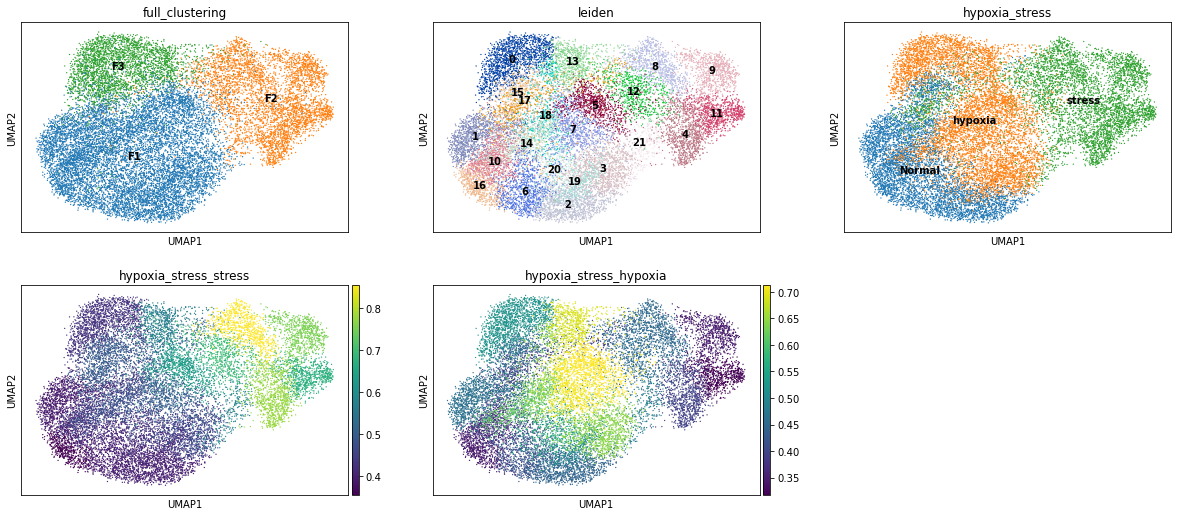

In [74]:
#Assess stress and hypoxia signature with Alex's function

sc.pl.umap(fb, color=['full_clustering', 'leiden', 'hypoxia_stress', 
                                             'hypoxia_stress_stress', 'hypoxia_stress_hypoxia'], 
           use_raw=False, ncols=3, legend_loc='on data')



***(2) Apply Alex's function to our data with different gene signatures (TNF and IFN)***



In [123]:
#Import GSEA interferon and TNF signatures

os.chdir('/home/ngr18/hcaskin/alex_reply')
ifn_genes = np.loadtxt('ifn_response.txt', dtype=str)
tnf_genes = np.loadtxt('TNFA_signalling.txt', dtype = str)

In [124]:
#Use Alex's function with interferon and TNF scores

dict_cats = {'tnf': tnf_genes, 'ifn': ifn_genes}

assign_cats(fb, dict_cats=dict_cats, column_groupby='leiden', intermediate_states=True, min_score=0.5,
            key_added='tnf_ifn')

/home/ngr18/anaconda3/envs/covid_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Gene CCN1 is not on the list
Gene CD80 is not on the list
Gene CSF2 is not on the list
Gene F2RL1 is not on the list
Gene IL12B is not on the list
Gene IL1A is not on the list
Gene OLR1 is not on the list
Gene PLEK is not on the list
Gene WARS1 is not on the list


<ipython-input-6-5686e8328888>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f'{key_added}'][adata.obs[f'{key_added}_max'] < min_score] = others_name


/home/ngr18/anaconda3/envs/covid_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


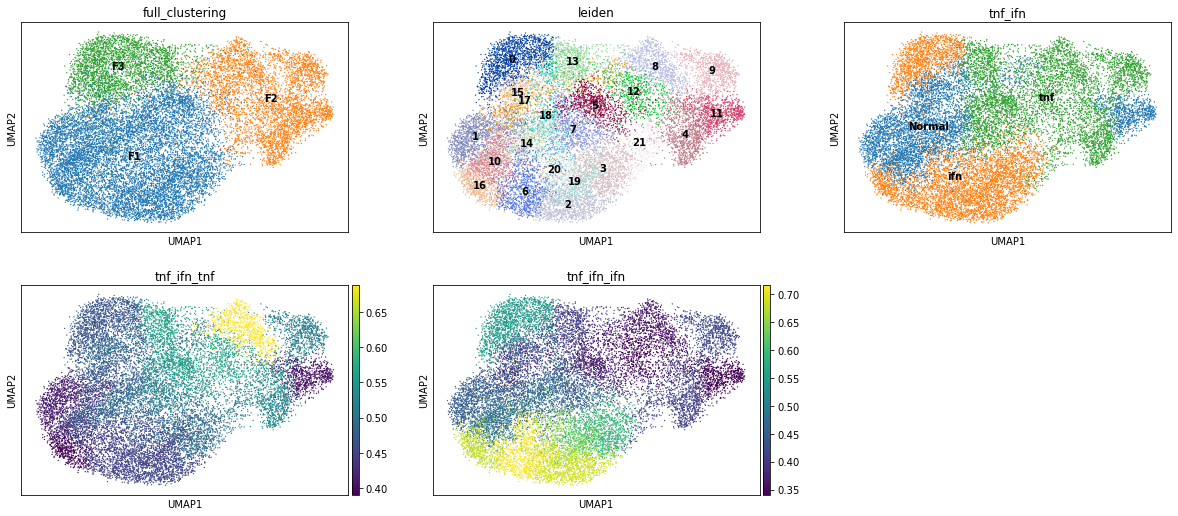

In [130]:
sc.pl.umap(fb, color=['full_clustering', 'leiden', 'tnf_ifn', 
                                             'tnf_ifn_tnf', 'tnf_ifn_ifn'], 
           use_raw=False, ncols=3, legend_loc='on data')



***(3) Apply Alex's function with stress and hypoxia signatures on Sole-Boldo datasets***



In [38]:
#import Sole-Boldo dataset

os.chdir('/home/ngr18/hcaskin/spanish_reply/sole')
sole = sc.read_10x_mtx('./',  cache=True)  

/home/ngr18/anaconda3/envs/covid_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [40]:
sc.pp.filter_cells(sole, min_genes=200)
sc.pp.filter_genes(sole, min_cells=3)

sole.var['mt'] = sole.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sole, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sole = sole[sole.obs.n_genes_by_counts > 200, :]

sc.pp.normalize_per_cell(sole)
sc.pp.log1p(sole)
sc.pp.highly_variable_genes(sole)
sc.pp.pca(sole, n_comps=30)

In [50]:
sole.obs['donor_id'] = sole.obs.index.str.split('-', expand = True).droplevel()

/home/ngr18/anaconda3/envs/covid_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'donor_id' as categorical


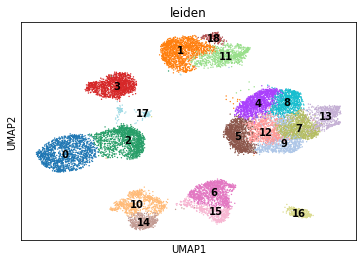

In [54]:
import bbknn
bbknn.bbknn(sole, batch_key='donor_id', copy=False)

sc.tl.leiden(sole, resolution=1.6, key_added='leiden')
sc.tl.umap(sole)

sc.pl.umap(sole, color='leiden', legend_loc='on data')

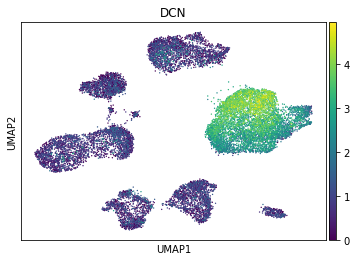

In [55]:
sc.pl.umap(sole, color='DCN', legend_loc='on data')

In [58]:
#separate fibroblasts

sole_fb = sole[sole.obs.leiden.isin(['4','5','7','8','9','12','13']),:]

In [126]:
#Use Alex's function on Sole-Boldo data

dict_cats = {'hypoxia': hypoxia_genes, 'stress': stress_genes}

assign_cats(sole_fb, dict_cats=dict_cats, column_groupby='leiden', intermediate_states=True, min_score=0.5,
            key_added='hypoxia_stress')

/home/ngr18/anaconda3/envs/covid_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Gene ALDOB is not on the list
Gene CCN2 is not on the list
Gene ERO1A is not on the list
Gene NA is not on the list


<ipython-input-6-5686e8328888>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f'{key_added}'][adata.obs[f'{key_added}_max'] < min_score] = others_name


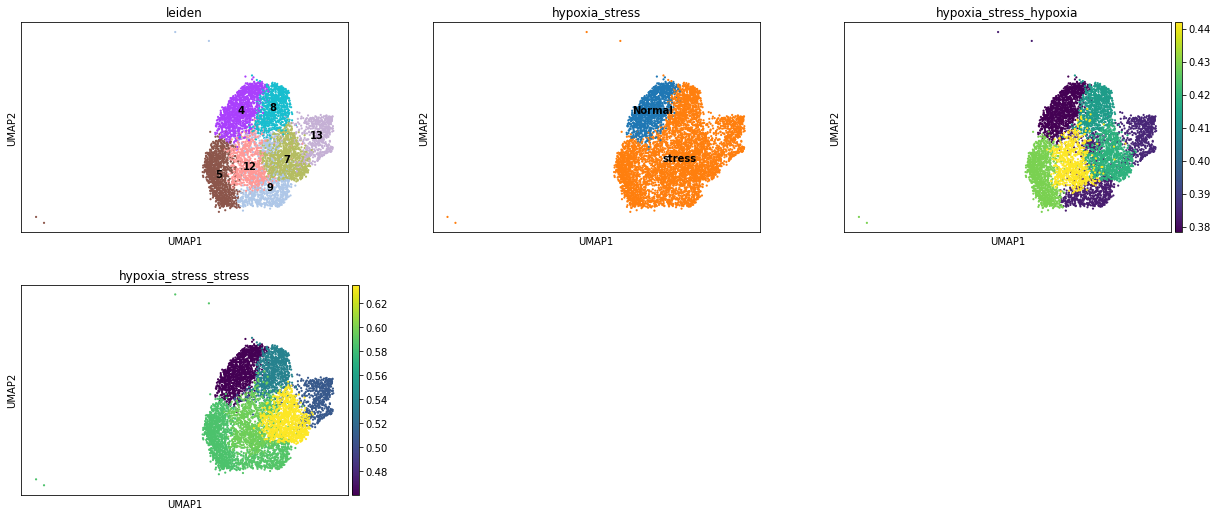

In [128]:
sc.pl.umap(sole_fb, color=['leiden', 'hypoxia_stress', 'hypoxia_stress_hypoxia', 'hypoxia_stress_stress'], 
           use_raw=False, ncols=3, legend_loc='on data')